In [1]:
from pylab import *
from numpy import *
from scipy import linalg


def compute_P(x,X):
    """    Compute camera matrix from pairs of
        2D-3D correspondences (in homog. coordinates). """

    n = x.shape[1]
    if X.shape[1] != n:
        raise ValueError("Number of points don't match.")
        
    # create matrix for DLT solution
    M = zeros((3*n,12+n))
    for i in range(n):
        M[3*i,0:4] = X[:,i]
        M[3*i+1,4:8] = X[:,i]
        M[3*i+2,8:12] = X[:,i]
        M[3*i:3*i+3,i+12] = -x[:,i]
        
    U,S,V = linalg.svd(M)
    
    return V[-1,:12].reshape((3,4))


def triangulate_point(x1,x2,P1,P2):
    """ Point pair triangulation from 
        least squares solution. """
        
    M = zeros((6,6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2

    U,S,V = linalg.svd(M)
    X = V[-1,:4]

    return X / X[3]


def triangulate(x1,x2,P1,P2):
    """    Two-view triangulation of points in 
        x1,x2 (3*n homog. coordinates). """
        
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    X = [ triangulate_point(x1[:,i],x2[:,i],P1,P2) for i in range(n)]
    return array(X).T


def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = linalg.svd(F)
    S[2] = 0
    F = dot(U,dot(diag(S),V))
    
    return F/F[2,2]


def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        (Use with F.T for left epipole.) """
    
    # return null space of F (Fx=0)
    U,S,V = linalg.svd(F)
    e = V[-1]
    return e/e[2]
    
    
def plot_epipolar_line(im,F,x,epipole=None,show_epipole=True):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = dot(F,x)
    
    # epipolar line parameter and values
    t = linspace(0,n,100)
    lt = array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')
    

def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """

    return array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])


def compute_P_from_fundamental(F):
    """    Computes the second camera matrix (assuming P1 = [I 0]) 
        from a fundamental matrix. """
        
    e = compute_epipole(F.T) # left epipole
    Te = skew(e)
    return vstack((dot(Te,F.T).T,e)).T


def compute_P_from_essential(E):
    """    Computes the second camera matrix (assuming P1 = [I 0]) 
        from an essential matrix. Output is a list of four 
        possible camera matrices. """
    
    # make sure E is rank 2
    U,S,V = svd(E)
    if det(dot(U,V))<0:
        V = -V
    E = dot(U,dot(diag([1,1,0]),V))    
    
    # create matrices (Hartley p 258)
    Z = skew([0,0,-1])
    W = array([[0,-1,0],[1,0,0],[0,0,1]])
    
    # return all four solutions
    P2 = [vstack((dot(U,dot(W,V)).T,U[:,2])).T,
             vstack((dot(U,dot(W,V)).T,-U[:,2])).T,
            vstack((dot(U,dot(W.T,V)).T,U[:,2])).T,
            vstack((dot(U,dot(W.T,V)).T,-U[:,2])).T]

    return P2


def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the normalized 8 point algorithm. """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = mean(x1[:2],axis=1)
    S1 = sqrt(2) / std(x1[:2])
    T1 = array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = mean(x2[:2],axis=1)
    S2 = sqrt(2) / std(x2[:2])
    T2 = array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = dot(T1.T,dot(F,T2))

    return F/F[2,2]


class RansacModel(object):
    """ Class for fundmental matrix fit with ransac.py from
        http://www.scipy.org/Cookbook/RANSAC"""
    
    def __init__(self,debug=False):
        self.debug = debug
    
    def fit(self,data):
        """ Estimate fundamental matrix using eight 
            selected correspondences. """
        
        # transpose and split data into the two point sets
        data = data.T
        x1 = data[:3,:8]
        x2 = data[3:,:8]
        
        # estimate fundamental matrix and return
        F = compute_fundamental_normalized(x1,x2)
        return F
    
    def get_error(self,data,F):
        """ Compute x^T F x for all correspondences, 
            return error for each transformed point. """
        
        # transpose and split data into the two point
        data = data.T
        x1 = data[:3]
        x2 = data[3:]
        
        # Sampson distance as error measure
        Fx1 = dot(F,x1)
        Fx2 = dot(F,x2)
        denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
        err = ( diag(dot(x1.T,dot(F,x2))) )**2 / denom 
        
        # return error per point
        return err


def F_from_ransac(x1,x2,model,maxiter=5000,match_theshold=1e-6):
    """ Robust estimation of a fundamental matrix F from point 
        correspondences using RANSAC (ransac.py from
        http://www.scipy.org/Cookbook/RANSAC).
        input: x1,x2 (3*n arrays) points in hom. coordinates. """

    import ransac

    data = vstack((x1,x2))
    
    # compute F and return with inlier index
    F,ransac_data = ransac.ransac(data.T,model,8,maxiter,match_theshold,20,return_all=True)
    return F, ransac_data['inliers']

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('Stereo_images/image11.png',0)  #queryimage # left image
img2 = cv2.imread('Stereo_images/image12.png',0) #trainimage # right image

sift = cv2.xfeatures2d.SURF_create(100)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
print(pts1)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

[(198.18968200683594, 235.29238891601562), (19.953231811523438, 395.0826416015625), (328.4796142578125, 553.8242797851562), (352.47857666015625, 507.0489501953125), (546.1536865234375, 691.7758178710938), (357.3904113769531, 490.659423828125), (441.4590759277344, 614.606689453125), (369.08001708984375, 538.5015869140625), (441.4261779785156, 614.640380859375), (463.4059143066406, 678.0550537109375), (368.49481201171875, 597.6843872070312), (486.19744873046875, 660.015625), (461.0818786621094, 615.99609375), (459.8295593261719, 230.65774536132812), (301.5451354980469, 545.9202270507812), (38.37253189086914, 393.84393310546875), (449.7528991699219, 598.65234375), (21.132381439208984, 128.4357452392578), (206.3988494873047, 267.8792724609375), (523.6754760742188, 691.05712890625), (363.9040222167969, 465.66168212890625), (694.939697265625, 305.53558349609375), (485.94219970703125, 416.8441162109375), (946.6805419921875, 649.0977172851562), (242.28245544433594, 76.69706726074219), (461.372

In [6]:
a = [1,2,3]
b = [4,5,6]
c = [[2,2,2],[2,2,2],[2,2,2]]

out = np.matmul(np.matmul(b, c), np.transpose(a))
# out = (b)*np.array(c)*np.transpose(a)
print(out)

180


In [4]:
a = [[1,2,3], [1,2,3], [2,3,4]]
print(a[0,1])

TypeError: list indices must be integers or slices, not tuple

(768, 1026)
(768, 1024)
[[ 1.84094523e-07  1.43030239e-05 -9.89011893e-03]
 [-9.38494947e-06 -1.79497615e-06 -1.36396624e-01]
 [ 8.17350914e-03  1.35309245e-01  1.00000000e+00]]


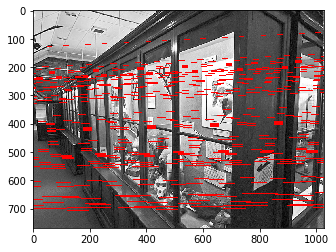

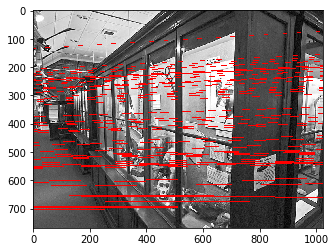

In [45]:
choose = 1

if choose == 1:
    path_p = './Stereo_images/image11.png'
    path_q = './Stereo_images/image12.png'
elif choose == 2:
    path_p = './Stereo_images/image21.png'
    path_q = './Stereo_images/image22.png'    
elif choose == 3:
    path_p = './Stereo_images/image31.png'
    path_q = './Stereo_images/image32.png'    
elif choose == 4:
    path_p = './Stereo_images/image41.png'
    path_q = './Stereo_images/image42.png'    
elif choose == 5:
    path_p = './Stereo_images/image51.png'
    path_q = './Stereo_images/image52.png' 


import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread(path_p, cv2.IMREAD_UNCHANGED)  #queryimage # left image
img2 = cv2.imread(path_q, cv2.IMREAD_UNCHANGED) #trainimage # right image
if choose != 4:
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
print(img1.shape)
print(img2.shape)

# sift = cv2.SIFT()
surf = cv2.xfeatures2d.SURF_create(100)

# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = pts1[:100]
pts2 = pts2[:100]
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
#         color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
#         img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
#         img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
#         img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
        img1 = cv2.line(img1, (x0,y0), (x1,y1), (255,0,0),1)
#         img1 = cv2.circle(img1,tuple(pt1),5,(0,255,0),-1)
#         img2 = cv2.circle(img2,tuple(pt2),5,(0,0,255),-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
print(F)
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.imshow(img5)
plt.show()
plt.imshow(img3)
# plt.subplot(121),
# plt.subplot(122),
plt.show()

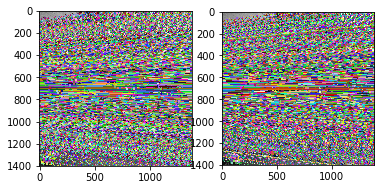

In [62]:
choose = 5

if choose == 1:
    path_p = './Stereo_images/image11.png'
    path_q = './Stereo_images/image12.png'
elif choose == 2:
    path_p = './Stereo_images/image21.png'
    path_q = './Stereo_images/image22.png'    
elif choose == 3:
    path_p = './Stereo_images/image31.png'
    path_q = './Stereo_images/image32.png'    
elif choose == 4:
    path_p = './Stereo_images/image41.png'
    path_q = './Stereo_images/image42.png'    
elif choose == 5:
    path_p = './Stereo_images/image51.png'
    path_q = './Stereo_images/image52.png' 

import cv2
import numpy as np
 
from matplotlib import pyplot as plt
 
 
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img1
        lines - corresponding epilines ''' 
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1), 10, color, -1)
        cv2.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2
  
img1 = cv2.imread(path_p,0)   # queryimage # left image
img2 = cv2.imread(path_q,0) #trainimage    # right image
# img1 = cv2.resize(img1, (0,0), fx=0.5, fy=0.5)
# img2 = cv2.resize(img2, (0,0), fx=0.5, fy=0.5)

sift = cv2.xfeatures2d.SURF_create(10)
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
 
flann = cv2.FlannBasedMatcher(index_params,search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
good = []
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts2 = np.float32(pts2)
pts1 = np.float32(pts1)       
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
 
# We select only first 15 points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
 
# drawing lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
 
# drawing lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
 
 
    
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()  